# Verification of Dynamical Simulation

**Yuning Zhang, TU Delft, 2021.10.23**

Verify the time evolution using a full scale Hamiltonian simulation, provided by `QuantumOptics.jl`. 

The function $f(t)=\langle S_x(t) \rangle$ generated by our code is compared with the simulation of `QuantumOptics.jl`. 
If the shape is the same then it's successful.

In [19]:
using QuantumOptics
using Plots
include("SpinEnsemble.jl")

ensemble_average_FID

## Free Induction Decay 

with zero transerve magnetic field (h=0)

In [2]:
b=SpinBasis(1//2)
sigma_z=sigmaz(b)
sigma_x=sigmax(b)
sigma_i=sigma_z*sigma_z

"""
contruct the Hamiltonian of the ensemble, 
Args:
    D: dipolar coupling strength 
    H_R: transerve magnetic field
"""
function ensemble_Hamiltonian(D::Vector{Float64},H_R::Float64)
    N=length(D)
    L=repeat([sigma_i],N)

    H=H_R*tensor(sigma_x/2,L...)
    for i in 1:N
        L[i]=sigma_z/2
        H+=2*D[i]*tensor(sigma_z/2,L...)
        L[i]=sigma_i
    end
    return H
end

ensemble_Hamiltonian

In [3]:
N=5
D=rand_bath_dipolar_coefs(N,3);
H=ensemble_Hamiltonian(D,0.0);
T=t_adaptive(D,1001)

### f(t) given by our code, via a product of cos terms

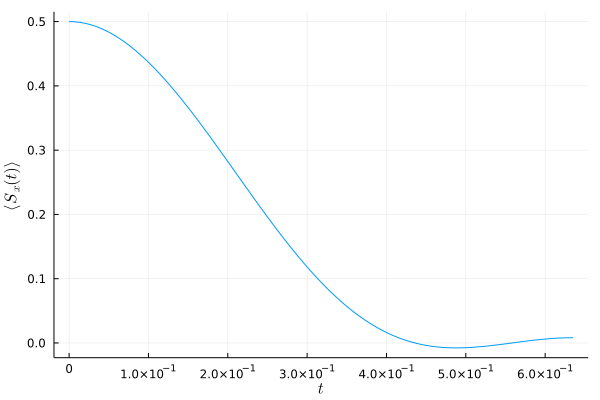

In [15]:
# plot the decay curve using the direct production
plot(T,ensemble_FID(T,D);FID_plot_options...)

### f(t) given by simulation

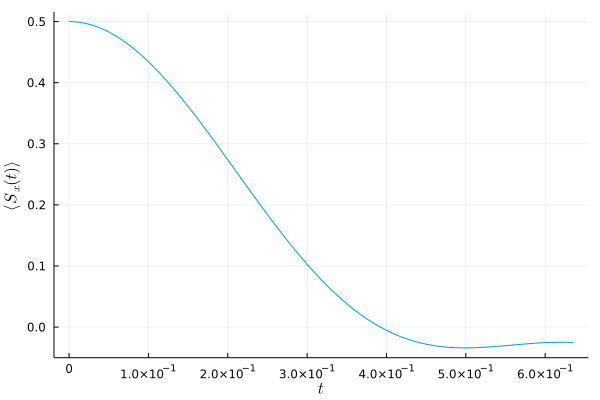

In [16]:
# plot the decay curve by simulating the time evolution of the composite system
sigma_x_0=tensor(sigma_x/2,repeat([sigma_i],N)...)
psi0=tensor(sigma_i/2+sigma_x/2,repeat([sigma_i/2],N)...)
exp_func(t, psi) = expect(sigma_x_0, psi)
tout, exp_val = timeevolution.schroedinger(2*T, psi0, H; fout=exp_func);
plot(T,real(exp_val);FID_plot_options...)

## Decay curve of the central spin under driving

with non-zero transerve magnetic field (h!=0)

In [17]:
N=5
D=rand_bath_dipolar_coefs(N,3,1.0);
H=ensemble_Hamiltonian(D,1.0);
T=0:0.01:2;

### f(t) from Monte-Carlo sampling 

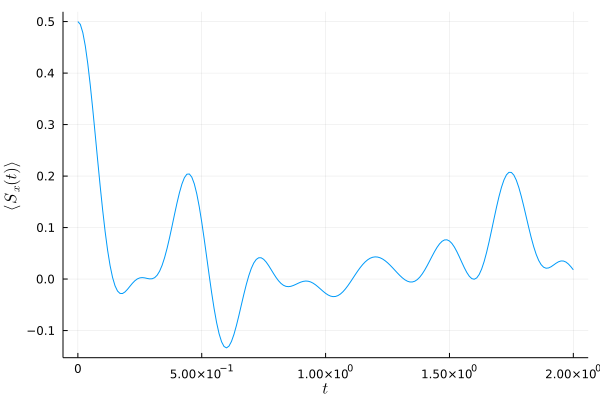

In [18]:
# plot the decay curve using the direct production
f_s=f_sampling(T,D,1.0;N=100)
plot(T,f_s;FID_plot_options...)

### f(t) from full scale simulation

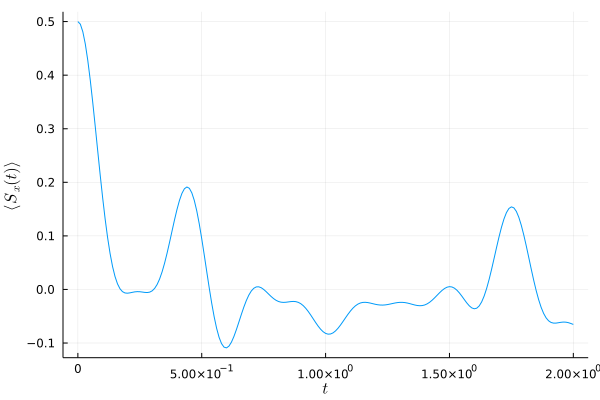

In [19]:
# plot the decay curve by simulating the time evolution of the composite system
sigma_x_0=tensor(sigma_x/2,repeat([sigma_i],N)...)
psi0=tensor(sigma_i/2+sigma_x/2,repeat([sigma_i/2],N)...)
exp_func(t, psi) = expect(sigma_x_0, psi)
tout, exp_val = timeevolution.schroedinger(2*T, psi0, H; fout=exp_func);
plot(T,real(exp_val),;FID_plot_options...)

## Check the exponential power of the decay curve

In [35]:
using LsqFit
import ProgressMeter: @showprogress

## Three Dimension

In [28]:
# set 500 spin, and h equals zero
D_3d=rand_bath_dipolar_coefs(500,3,1.0);
T_3d=t_adaptive(D_3d,1001,n_sigma=6);

In [29]:
FID_curve=mean(@showprogress [ensemble_FID(T_3d, rand_bath_dipolar_coefs(500,3,1.0)) for i in 1:10^3]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Free Induction Decay in 3 dimision

$$
f(t)\propto \exp[-(\frac{t}{T_2})^{2}]
$$


In [45]:
f_model(t,p)=exp.(-(t/p[1]).^2)/2
p0=[1.0]
fit = curve_fit(f_model, T_3d, FID_curve, p0);

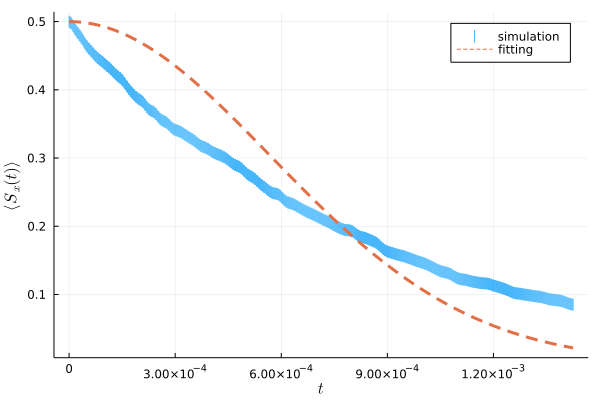

In [46]:
scatter(T_3d,FID_curve;FID_plot_options..., labels="simulation",
markershape = :vline,
markersize = 6,
markeralpha = 0.9
)

plot!(T_3d,f_model(T_3d,fit.param),linestyle=:dash,linewidth=3,label="fitting")